### 필요 라이브러리 로드

In [295]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [296]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [496]:
df=pd.read_excel("BG_sample18.xlsx")

In [497]:
df.shape

(1474, 14)

In [498]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1983-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,250,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,70,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,긴급하게 낮음,NaN,NaN,Android,55,NaN,NaN,NaN,NaN,NaN,NaN


In [499]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '인슐린 값(u)', '탄수화물 값 (그램)', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [500]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event'},axis='columns')

In [501]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
경고         6
교정         4
성          1
이름         1
장치         1
생년월일       1
Name: Event, dtype: int64

In [502]:
df['Glucose'].value_counts()

높음     169
199     27
187     20
185     19
197     18
      ... 
366      1
367      1
380      1
171      1
55       1
Name: Glucose, Length: 242, dtype: int64

In [503]:
df.tail()

,Timestamp,Event,Glucose
1469,2020-03-18T09:20:43,EGV,높음
1470,2020-03-18T09:25:44,EGV,높음
1471,2020-03-18T09:30:43,EGV,높음
1472,2020-03-18T09:35:44,EGV,높음
1473,2020-03-18T09:40:44,EGV,높음


In [504]:
df.head(15)

,Timestamp,Event,Glucose
0,NaN,이름,NaN
1,NaN,성,NaN
2,NaN,생년월일,NaN
3,NaN,장치,NaN
4,NaN,경고,NaN
5,NaN,경고,250
6,NaN,경고,70
7,NaN,경고,NaN
8,NaN,경고,NaN
9,NaN,경고,55


In [505]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [506]:
df.head(15)

,Timestamp,Event,Glucose
10,2020-03-13T11:05:03,교정,216
11,2020-03-13T11:14:06,교정,244
12,2020-03-13T11:15:55,EGV,227
13,2020-03-13T11:20:50,EGV,227
14,2020-03-13T11:25:49,EGV,224
15,2020-03-13T11:30:49,EGV,223
16,2020-03-13T11:35:49,EGV,222
17,2020-03-13T11:40:50,EGV,222
18,2020-03-13T11:45:51,EGV,218
19,2020-03-13T11:50:49,EGV,218


In [507]:
df.shape

(1464, 3)

In [508]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [509]:
df.head(15)

,Timestamp,Event,Glucose
0,2020-03-13T11:05:03,교정,216
1,2020-03-13T11:14:06,교정,244
2,2020-03-13T11:15:55,EGV,227
3,2020-03-13T11:20:50,EGV,227
4,2020-03-13T11:25:49,EGV,224
5,2020-03-13T11:30:49,EGV,223
6,2020-03-13T11:35:49,EGV,222
7,2020-03-13T11:40:50,EGV,222
8,2020-03-13T11:45:51,EGV,218
9,2020-03-13T11:50:49,EGV,218


In [510]:
df.shape

(1464, 3)

In [511]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]

In [512]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [513]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [514]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [515]:
glucose_count_high(df,'Glucose')

높음 :  169


In [516]:
print('높음 개수 :',len(high_list))

높음 개수 : 169


In [517]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [518]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [519]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [520]:
low_list

[]

In [521]:
calibration_count_low(df,'Event')

교정 :  4


In [522]:
calib_list

[0, 1, 139, 414]

In [523]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [524]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
교정         4
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [525]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400

In [526]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [527]:
fix_glucose(df,'Glucose')

In [528]:
fix_glucose_low(df,'Glucose')

In [529]:
df['Glucose'].value_counts()

400    169
199     27
187     20
185     19
197     18
      ... 
171      1
169      1
389      1
366      1
145      1
Name: Glucose, Length: 240, dtype: int64

In [530]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [531]:
df['Event'].unique()

array(['교정', 'EGV', '인슐린', '탄수화물'], dtype=object)

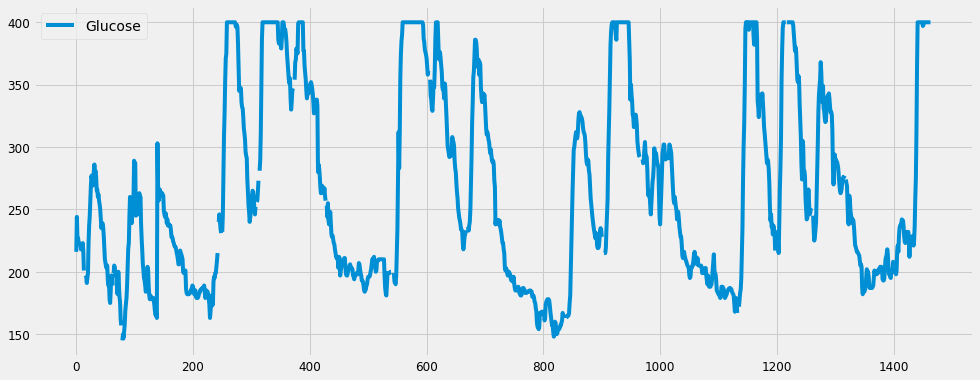

In [532]:
df.plot(figsize=(15,6))
plt.show()

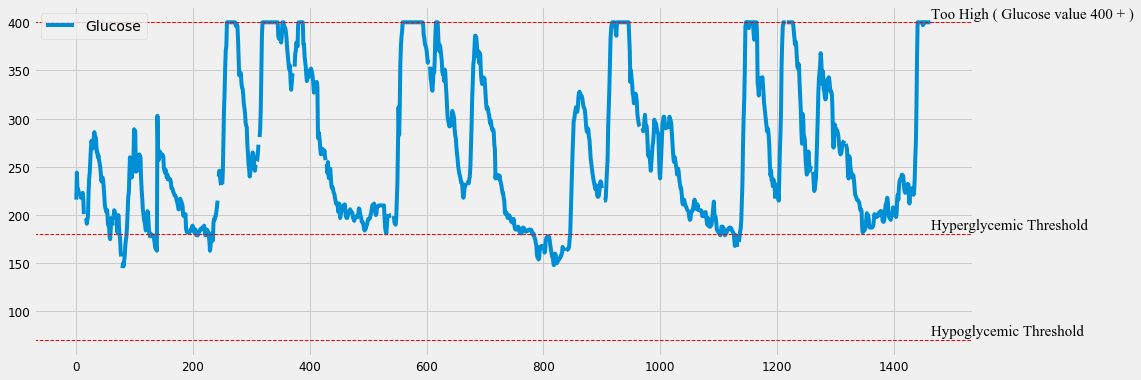

In [533]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [534]:
#df.drop(0,inplace=True)

In [535]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [536]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
insul=list()
meal=list()
import math
def interpolate_glucose(df,col):
    #insul=list()
    
    for i, row in df.iterrows():
        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
        if math.isnan(val):
            if df['Event'][i]=='인슐린':
                if df['Glucose'][i-1] is None:
                    insul.append(i-2)
                    
                    
                else:
                    insul.append(i-1)
                    
            if df['Event'][i]=='탄수화물':
                if df['Glucose'][i-1] is None:
                    meal.append(i-2)
                    
                else:
                    meal.append(i-1)
                    

In [537]:
interpolate_glucose(df,'Glucose')

In [538]:
meal

[14,
 77,
 248,
 312,
 372,
 540,
 542,
 604,
 669,
 836,
 902,
 966,
 967,
 1132,
 1197,
 1259,
 1430]

In [539]:
insul

[13,
 62,
 242,
 307,
 371,
 427,
 539,
 541,
 603,
 668,
 719,
 837,
 900,
 965,
 968,
 1133,
 1198,
 1215,
 1260,
 1316,
 1428]

In [439]:
df.head(21)

,Timestamp,Event,Glucose
0,2020-03-13T11:05:03,교정,216
1,2020-03-13T11:14:06,교정,244
2,2020-03-13T11:15:55,EGV,227
3,2020-03-13T11:20:50,EGV,227
4,2020-03-13T11:25:49,EGV,224
5,2020-03-13T11:30:49,EGV,223
6,2020-03-13T11:35:49,EGV,222
7,2020-03-13T11:40:50,EGV,222
8,2020-03-13T11:45:51,EGV,218
9,2020-03-13T11:50:49,EGV,218


In [45]:
glucose_value=list()
for i in range(0,len(insul)):
    glucose_value.append(df['Glucose'][insul[i]])

In [46]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

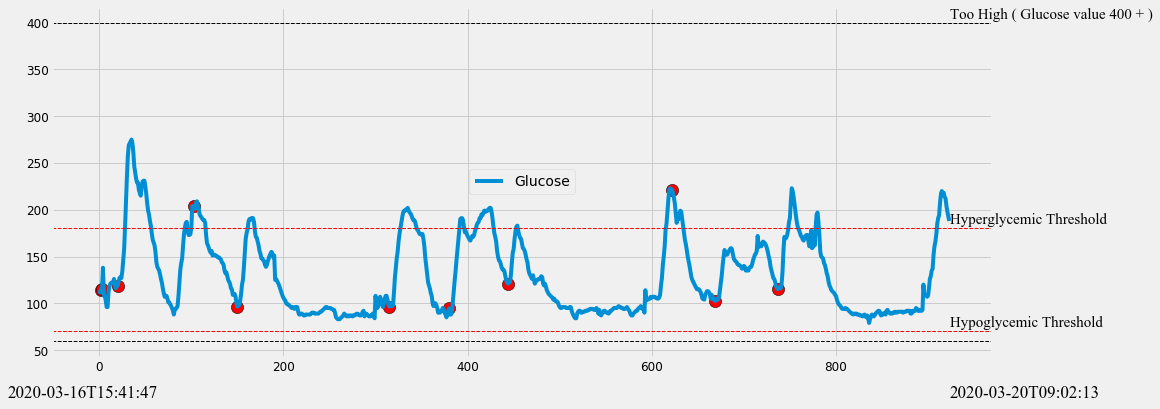

In [47]:

df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='black',linestyle='--',linewidth=1)
plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.scatter(insul,glucose_value,c='red',edgecolor='black',s=150)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',
#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [48]:
import numpy as np
import tensorflow as tf
import random as rn

In [49]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [50]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [51]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [52]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

## 15분

In [53]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [54]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

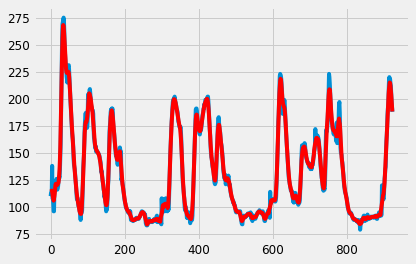

In [294]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [253]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [254]:
x_train_uni.shape

(640, 6, 1)

In [255]:
y_train_uni.shape

(640,)

In [256]:
x_train_uni[2]

array([[115.01426841],
       [121.34708575],
       [123.58507202],
       [118.54104186],
       [108.55951003],
       [ 99.19955579]])

In [257]:
y_train_uni[2]

110.17795121804494

In [258]:
df['Glucose'].head(10)

0    110.00
1    113.00
2    114.50
3    115.25
4    138.00
5    108.00
6    108.00
7    103.00
8     96.00
9     96.00
Name: Glucose, dtype: float64

### RNN - 15분

In [259]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [260]:
from keras.layers import SimpleRNN

In [261]:
n_steps = 3
#delay=3
n_features=1

In [262]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [263]:
K.set_session(sess)

In [264]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

In [265]:
model.compile(optimizer='adam',loss='mse')

In [266]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [267]:
K.clear_session()

In [268]:
predict_result = model.predict(x_val_uni,verbose=0)

In [269]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [270]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni,predict_result))
val_rnn_15 = RMSE(y_val_uni,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  10.208234406313718


#### Validation

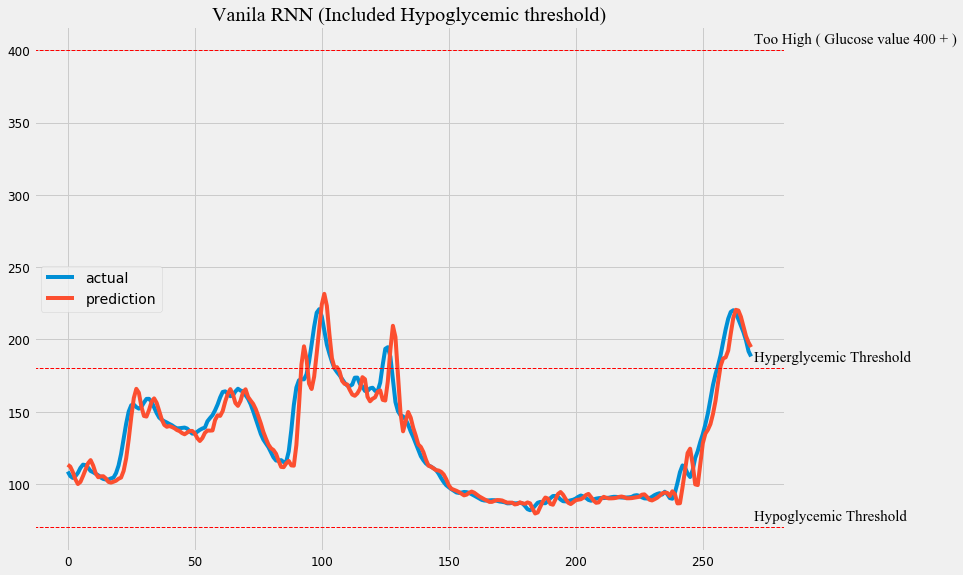

In [271]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [272]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

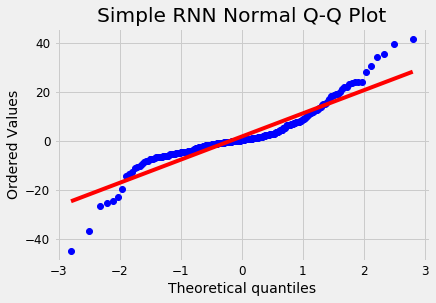

In [273]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

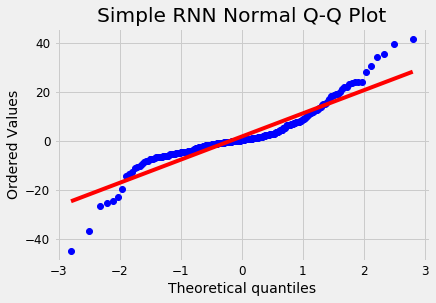

In [274]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [275]:
residuals=DataFrame(residuals)

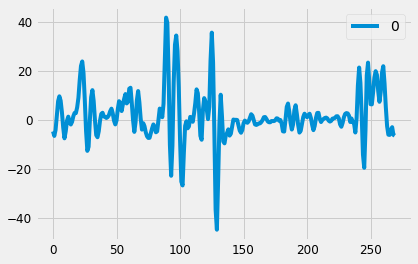

In [276]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AB1589FDF0>]],
      dtype=object)

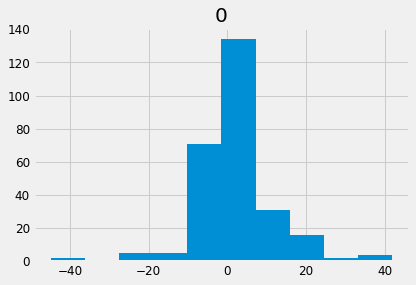

In [277]:

residuals.hist()

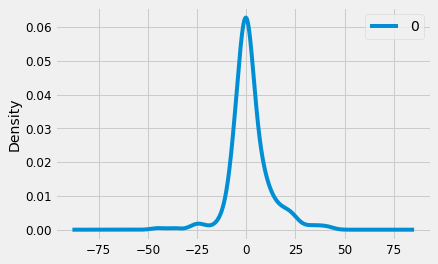

In [278]:
residuals.plot(kind='kde')

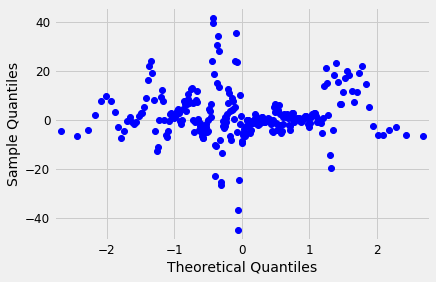

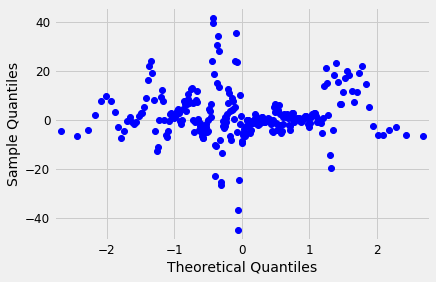

In [279]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [280]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni,predict_result))
train_rnn_15=RMSE(y_train_uni,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  9.3856099433389


#### Train

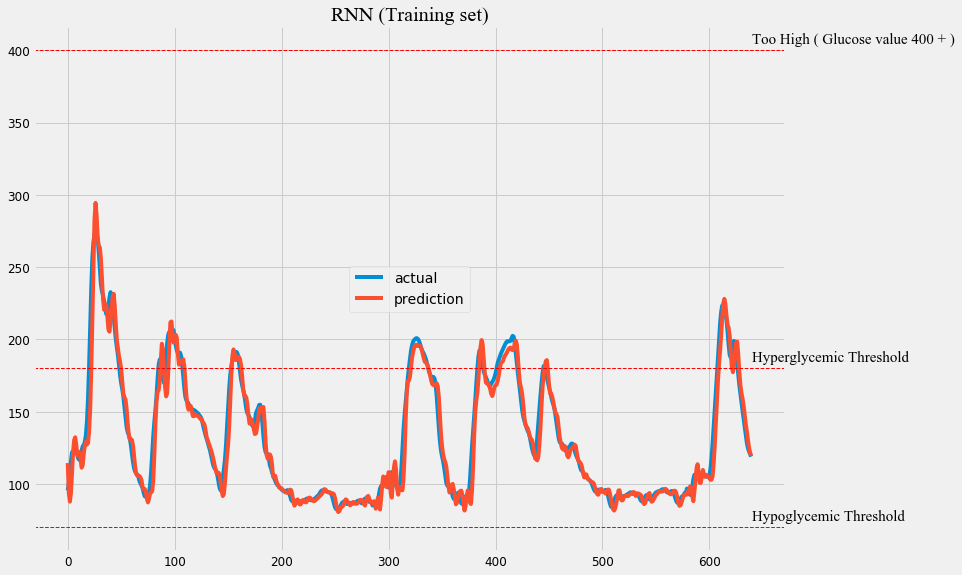

In [281]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

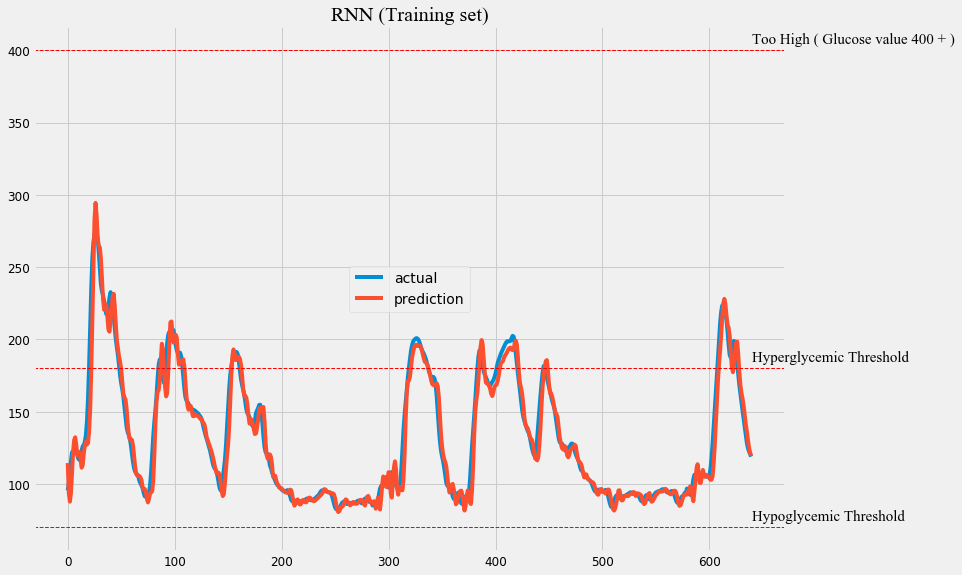

In [282]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [283]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [284]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


In [285]:
model.compile(optimizer='adam',loss='mse')

In [286]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [287]:
K.clear_session()

In [288]:
predict_result = model.predict(x_val_uni,verbose=0)

In [289]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [290]:
#predict_result

In [291]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni,predict_result))
val_lstm_15=RMSE(y_val_uni,predict_result)

 LSTM - RMSE (15min) :  9.709356096174632


In [95]:
TRAIN_SPLIT

646

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

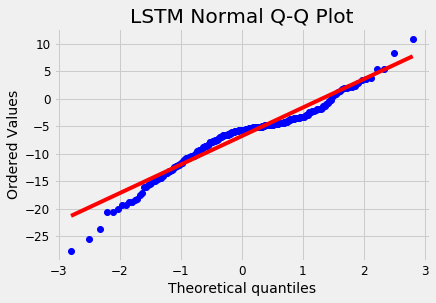

In [96]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

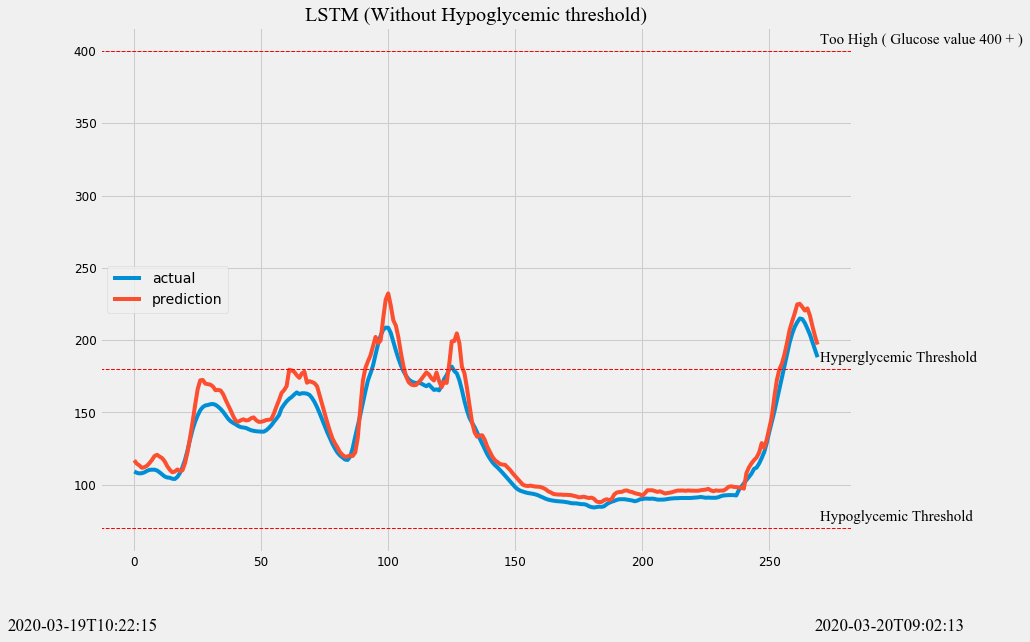

In [97]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [98]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_lstm_15 =RMSE(y_train_uni,predict_result)

 LSTM - RMSE (15min) Training set :  7.430844793791837


#### Train

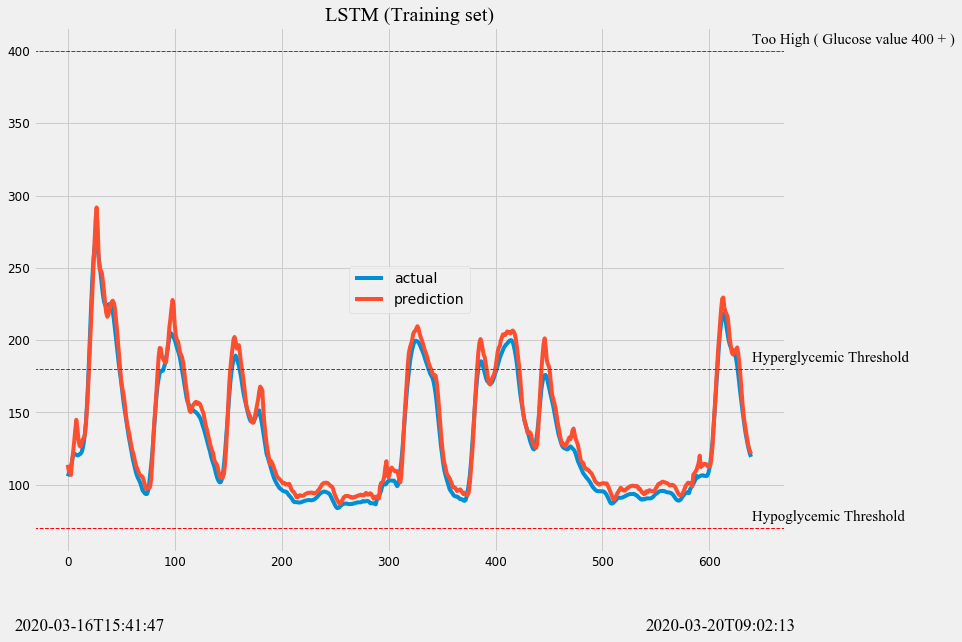

In [99]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [100]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [101]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [102]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [103]:
K.clear_session()

In [104]:
predict_result = model.predict(x_val_uni,verbose=0)


In [105]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [106]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni,predict_result))
val_stacklstm_15 =RMSE(y_val_uni,predict_result)

 Stacked LSTM - RMSE(15min) :  6.126397844003561


#### Validation

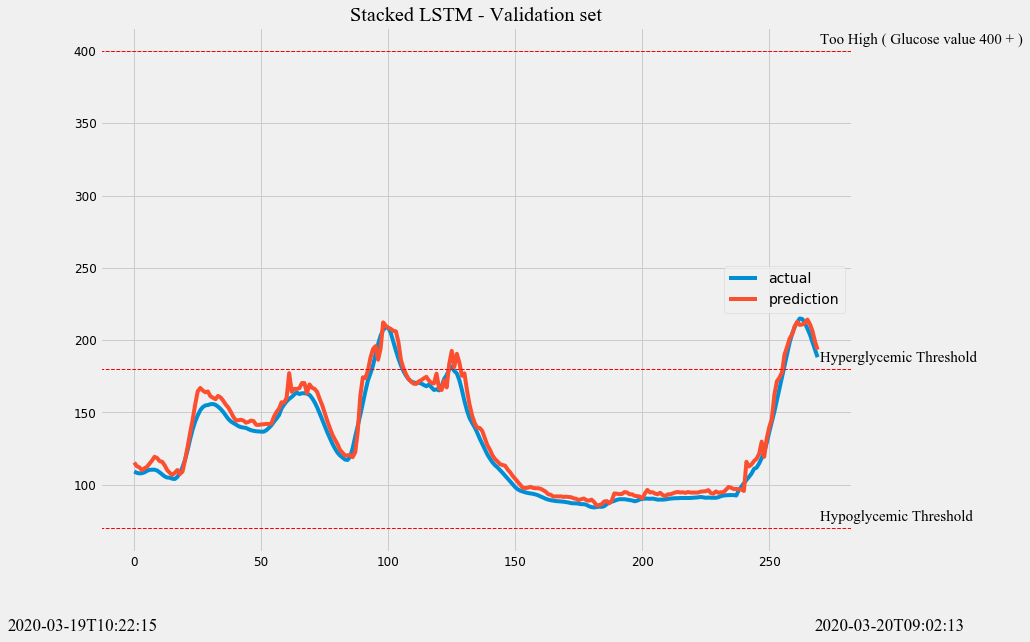

In [107]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

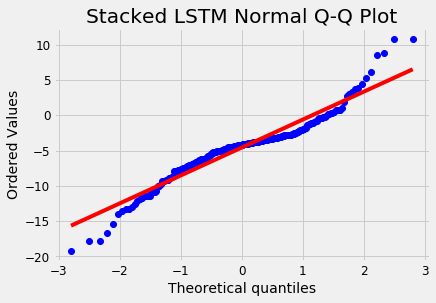

In [108]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [109]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_stacklstm_15 = RMSE(y_train_uni,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  5.929586334645083


#### Train

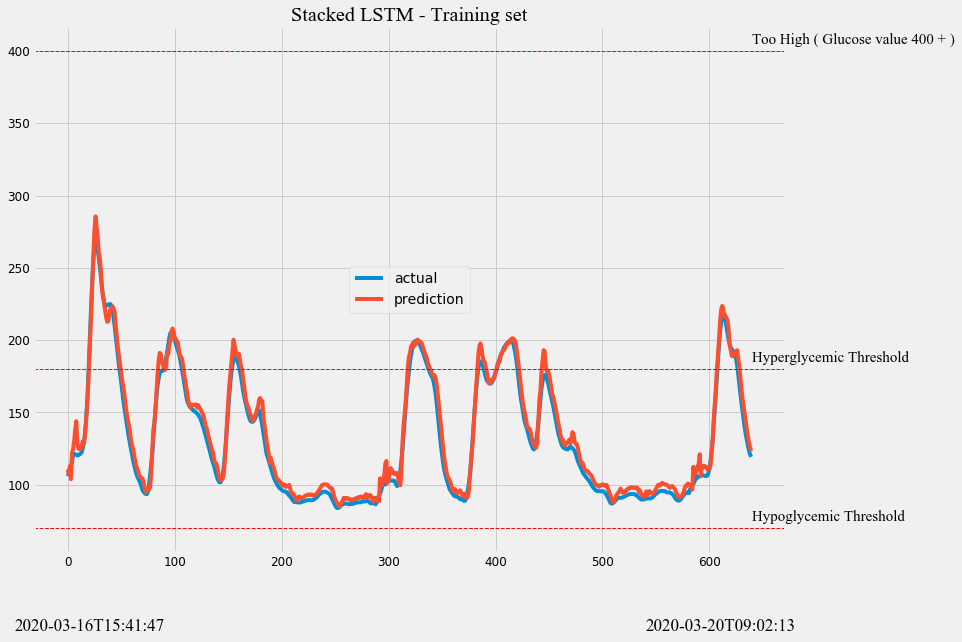

In [110]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [111]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [112]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [113]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [114]:
K.clear_session()

In [115]:
predict_result = model.predict(x_val_uni,verbose=0)

In [116]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [117]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni,predict_result))
val_bilstm_15 = RMSE(y_val_uni,predict_result)

Bidirectional LSTM - RMSE :  5.480938046283358


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

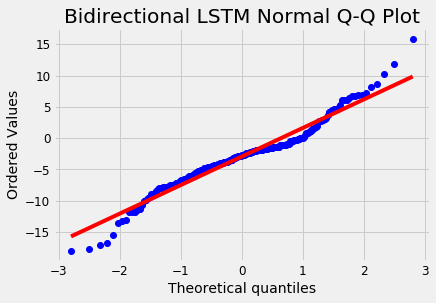

In [118]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

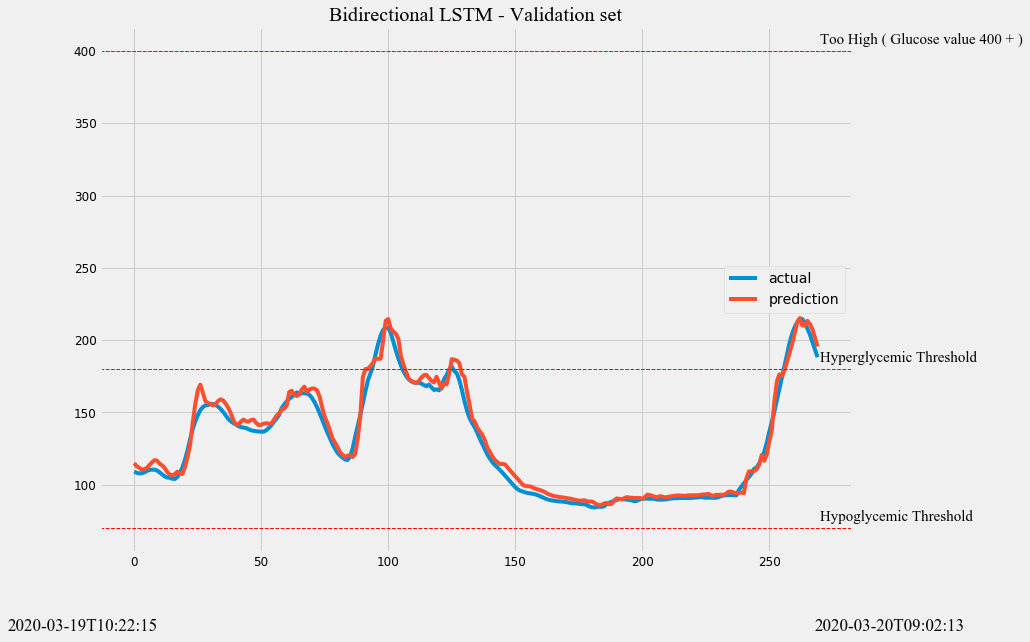

In [119]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [120]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))
train_bilstm_15 = RMSE(y_train_uni,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  5.256476717390221


#### Train

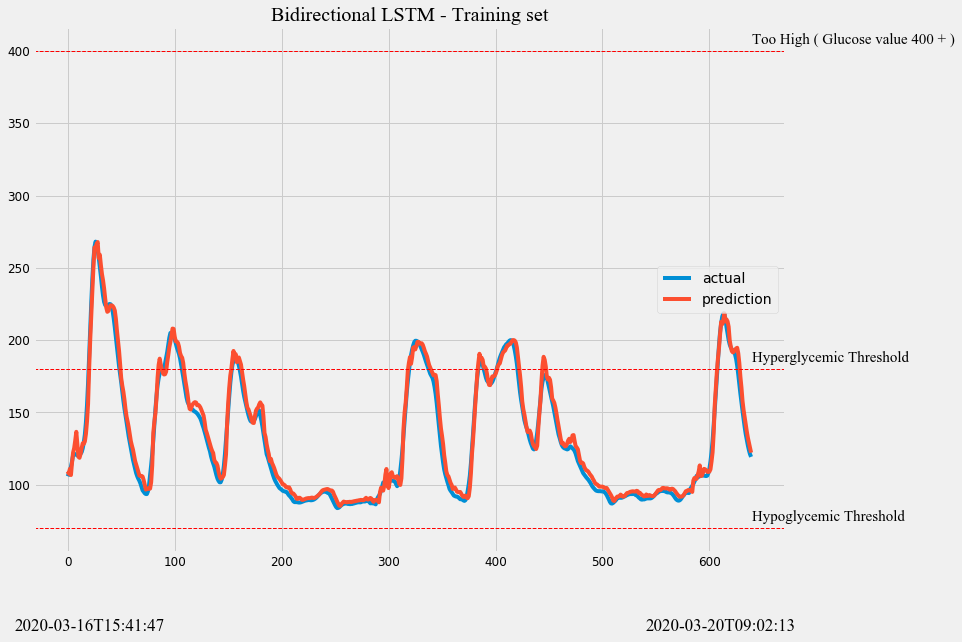

In [121]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [122]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [123]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [125]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [126]:
K.clear_session()

In [127]:
predict_result = model.predict(x_val_uni,verbose=0)

In [128]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [129]:
#predict_result

In [130]:
#predict_result

In [131]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_15 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  6.627783539971529


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

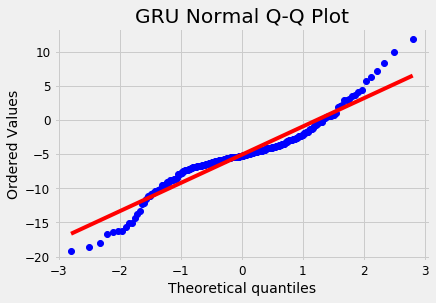

In [132]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

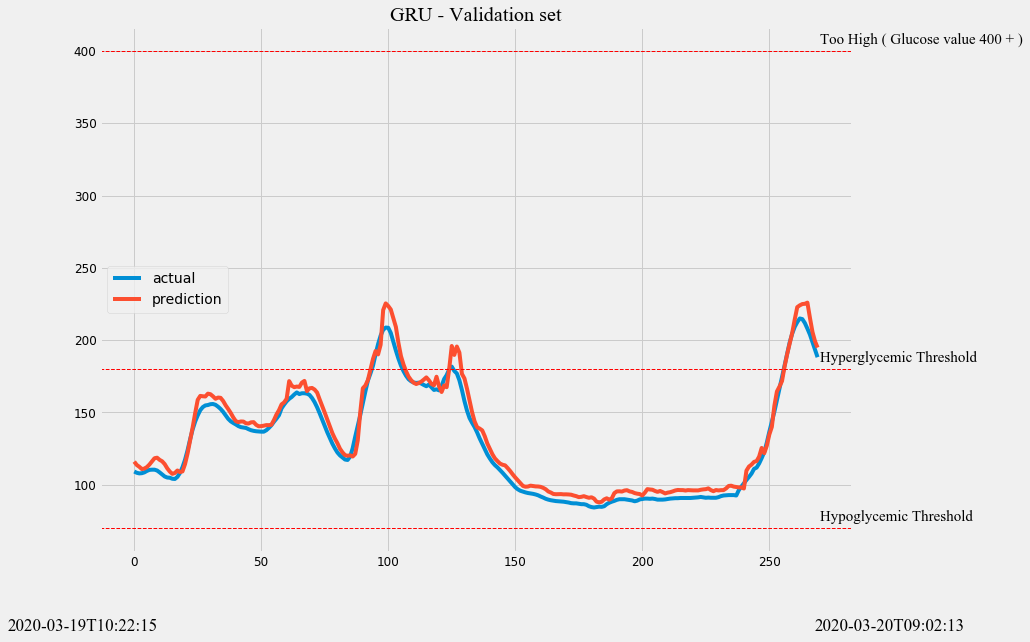

In [133]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [134]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_gru_15 =RMSE(y_train_uni,predict_result)

 Training set / GRU - RMSE (15min) Training set :  6.4541079090662175


#### Train

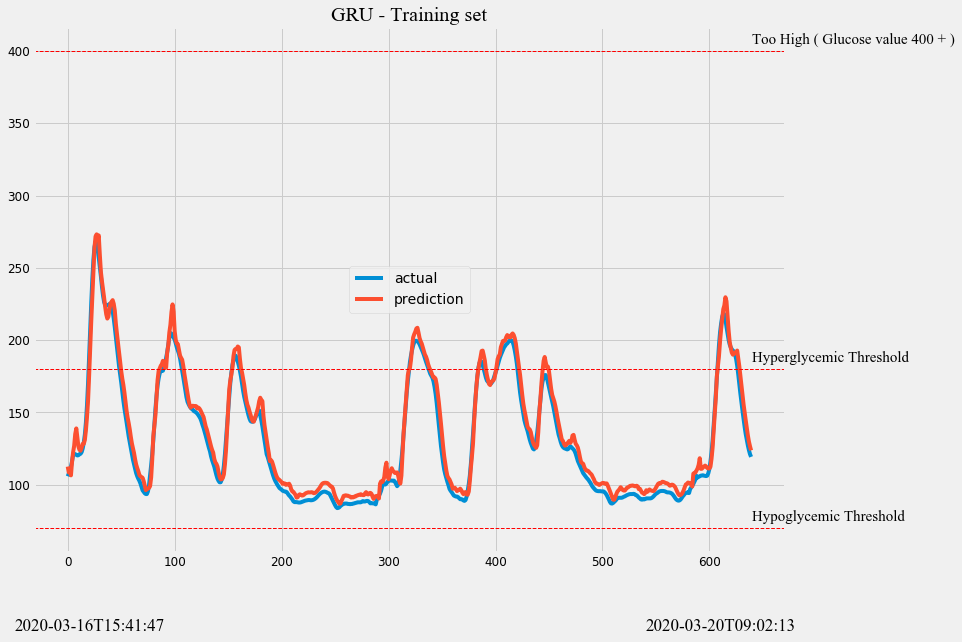

In [135]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [136]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [137]:
#residuals.plot(kind='kde')

In [138]:
#residuals.plot()

In [139]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

## 30분

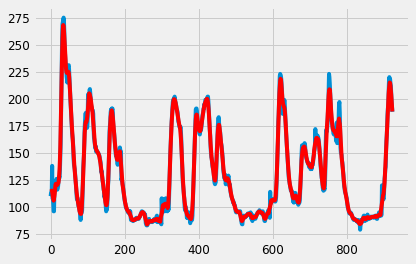

In [140]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [141]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [142]:
x_train_uni.shape


(640, 6, 1)

In [143]:

x_val_uni.shape

(267, 6, 1)

In [144]:
x_train_uni[0]

array([[114.28571429],
       [114.57142857],
       [114.85714286],
       [115.14285714],
       [114.14285714],
       [111.71428571]])

In [145]:
df['Glucose'].head(15)

0     110.00
1     113.00
2     114.50
3     115.25
4     138.00
5     108.00
6     108.00
7     103.00
8      96.00
9      96.00
10    112.00
11    118.00
12    121.00
13    122.00
14    122.00
Name: Glucose, dtype: float64

In [146]:
y_train_uni[0]

112.4285714285714

### RNN - 30분

In [147]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [148]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

In [149]:
model.compile(optimizer='adam',loss='mse')

In [150]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [151]:
K.clear_session()

In [152]:
predict_result = model.predict(x_val_uni,verbose=0)

In [153]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [154]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni,predict_result))
val_rnn_30 = RMSE(y_val_uni,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  11.624363717664115


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

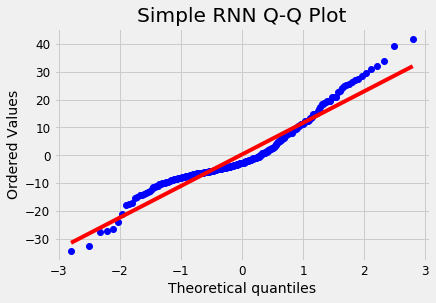

In [155]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

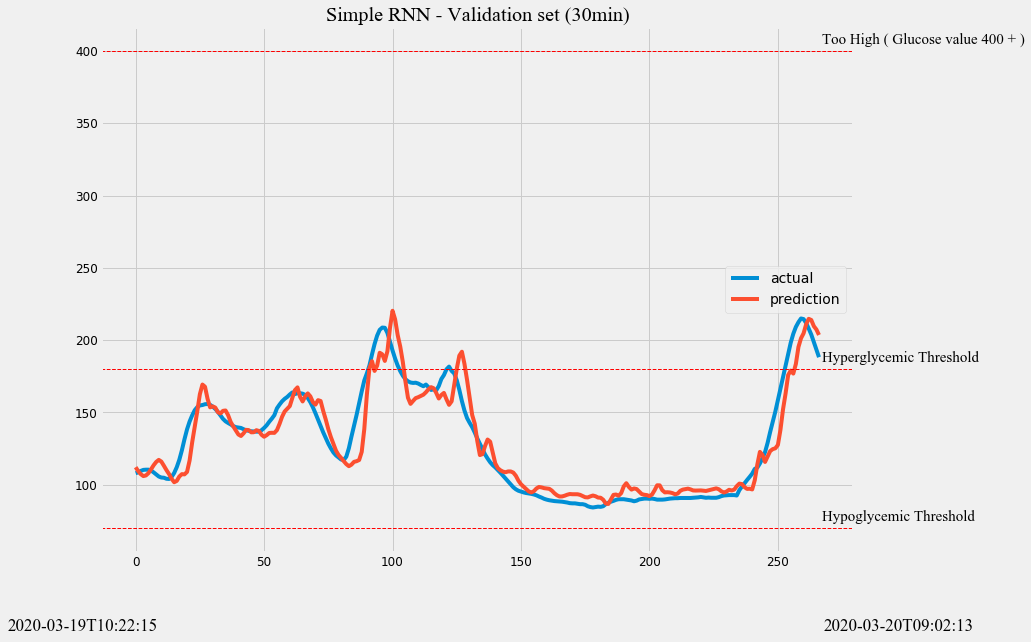

In [156]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

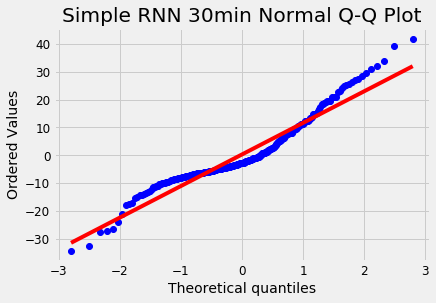

In [157]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [158]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni,predict_result))
train_rnn_30=RMSE(y_train_uni,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  13.73828724476204


#### Train

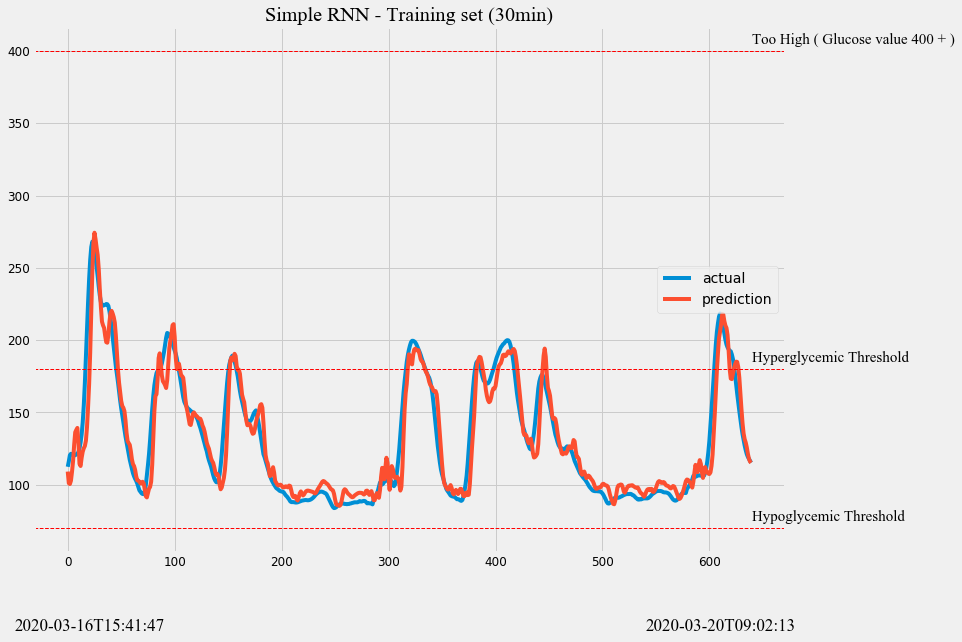

In [159]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [160]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [161]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


In [162]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [163]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni,predict_result))
val_lstm_30=RMSE(y_val_uni,predict_result)

 LSTM - RMSE (15min) :  13.759030331521492


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

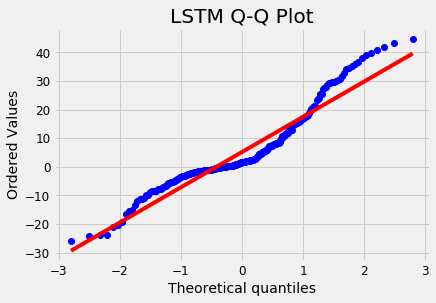

In [164]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

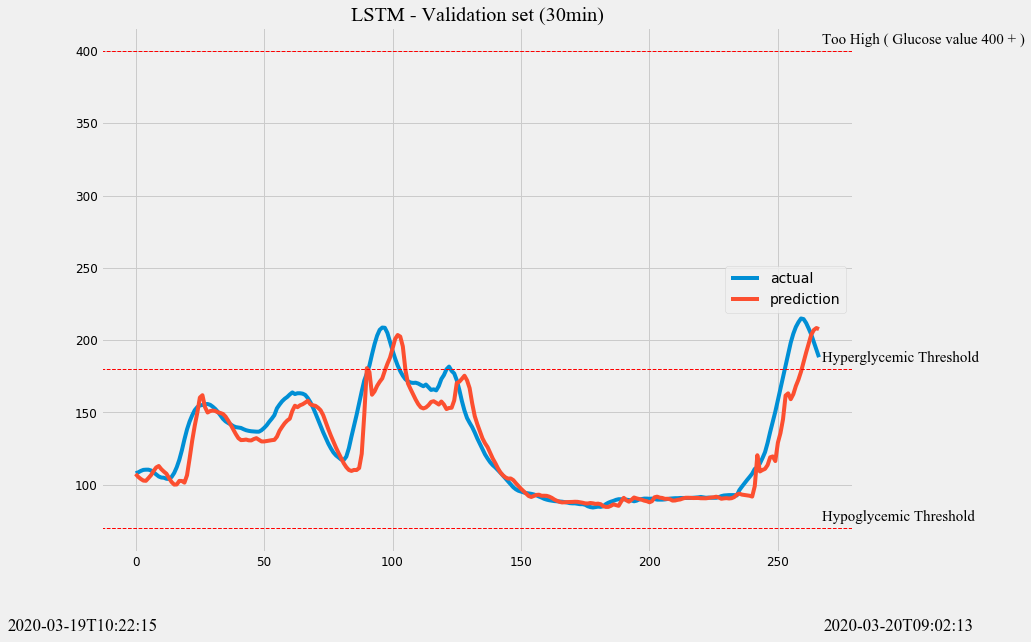

In [165]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [166]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_lstm_30 =RMSE(y_train_uni,predict_result)

 LSTM - RMSE (15min) Training set :  14.634018901453214


#### Train

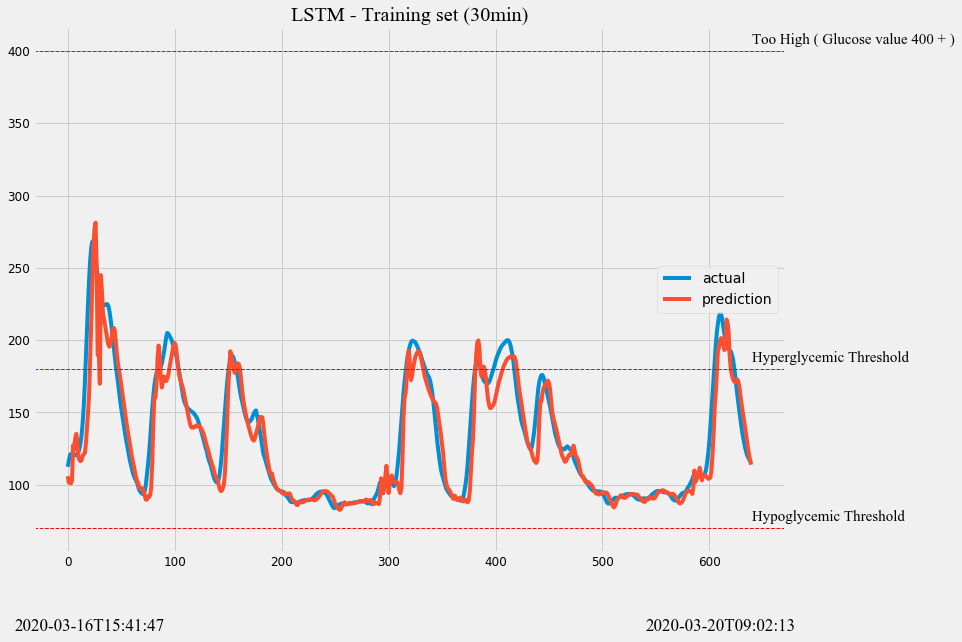

In [167]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [168]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [169]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [170]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [171]:
K.clear_session()

In [172]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni,predict_result))
val_stacklstm_30 =RMSE(y_val_uni,predict_result)

 Stacked LSTM - RMSE(15min) :  10.726577274690678


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

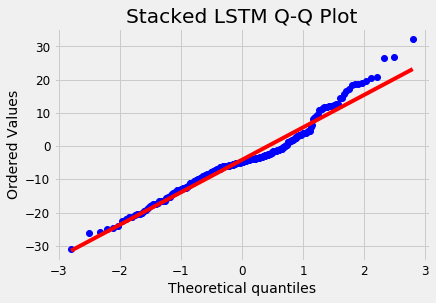

In [173]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

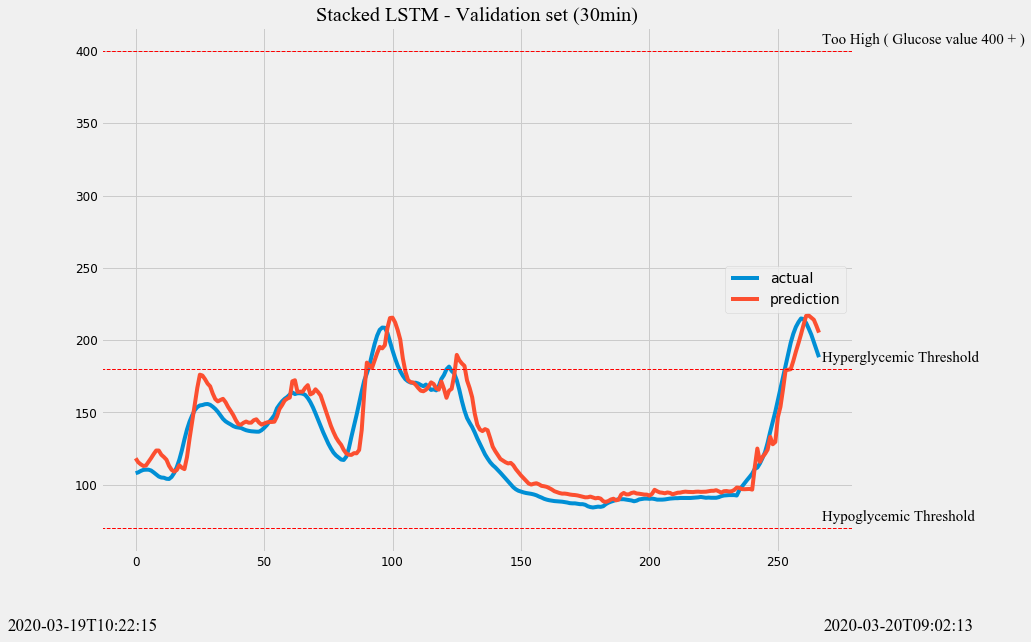

In [174]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [175]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_stacklstm_30 = RMSE(y_train_uni,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  13.210074239033592


#### Train

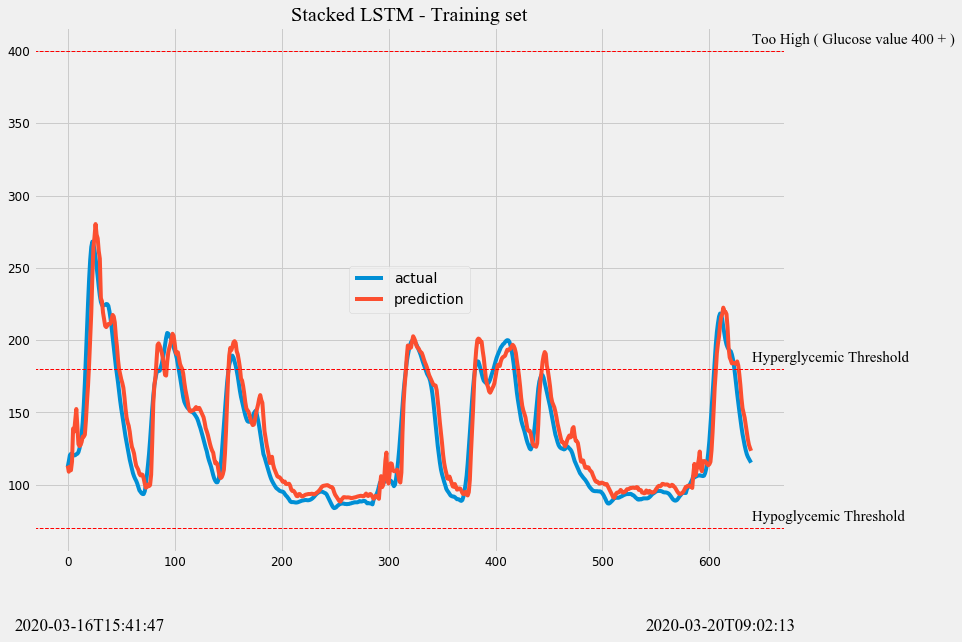

In [176]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [177]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [178]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [179]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [180]:
K.clear_session()

In [181]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni,predict_result))
val_bilstm_30 = RMSE(y_val_uni,predict_result)

Bidirectional LSTM - RMSE :  11.782337598429969


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

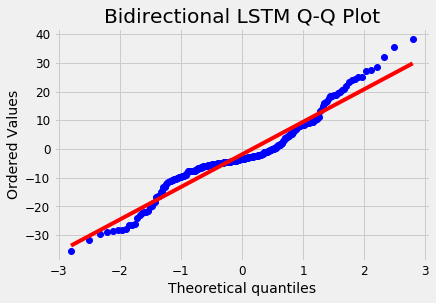

In [182]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

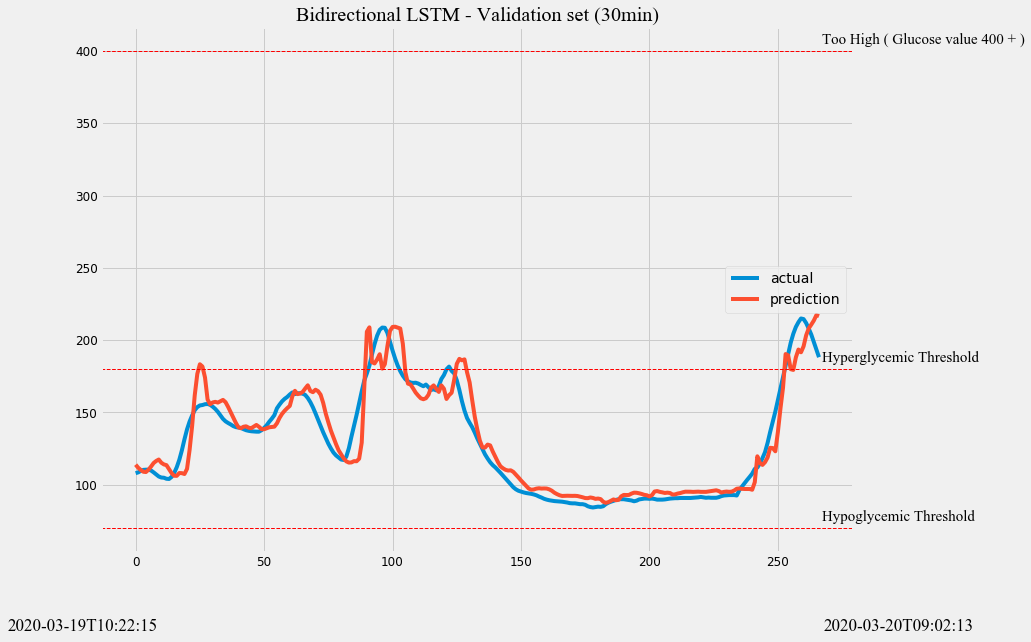

In [183]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [184]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni,predict_result))
train_bilstm_30 = RMSE(y_train_uni,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  12.026636421556999


#### Train

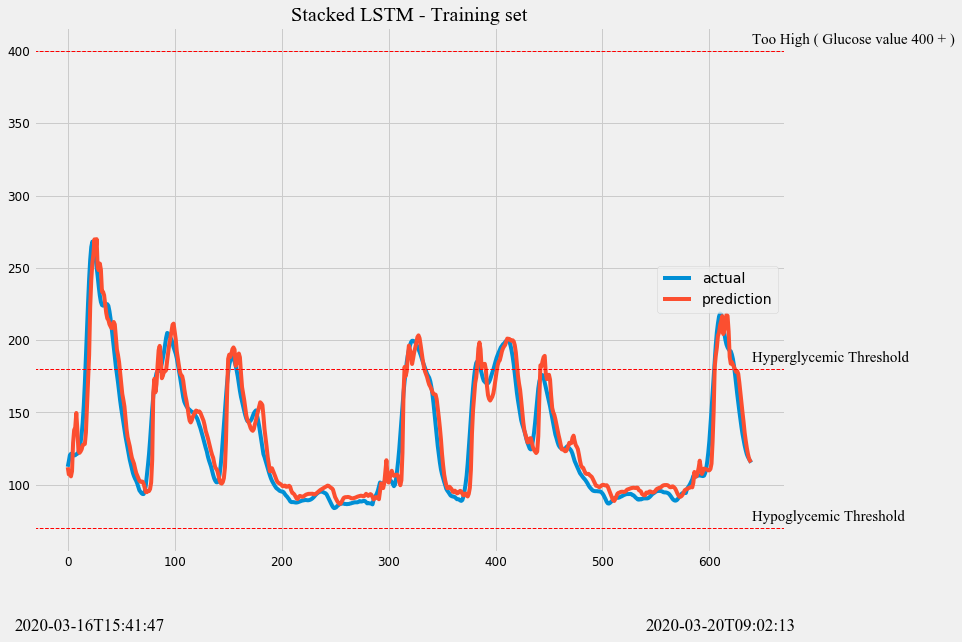

In [185]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [186]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [187]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [188]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [189]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  9.753757596619186


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

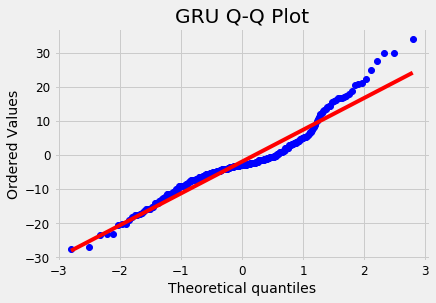

In [190]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

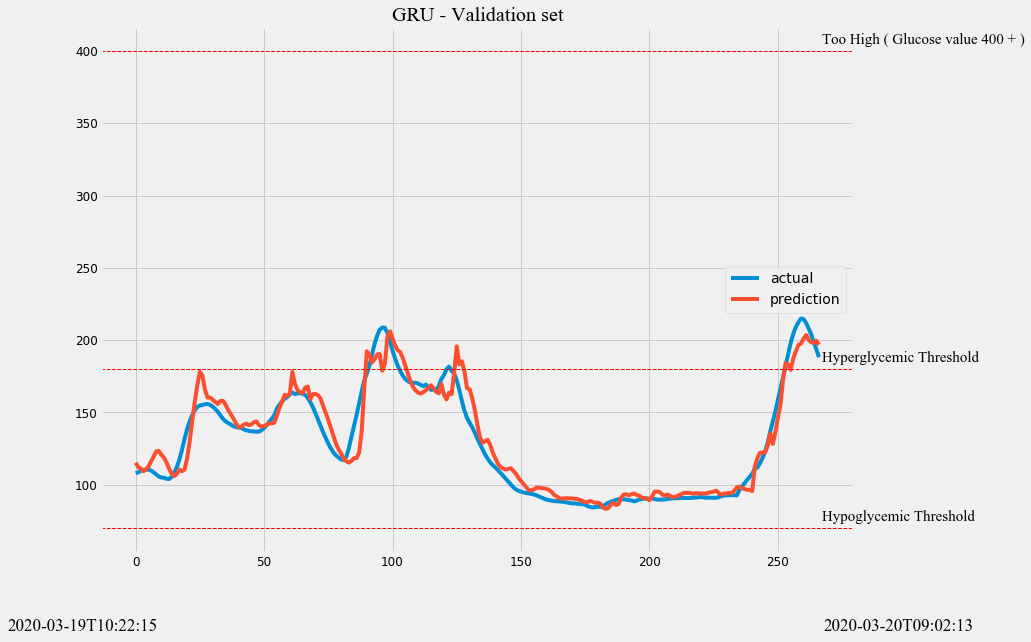

In [191]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [192]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni,predict_result))
train_gru_30 =RMSE(y_train_uni,predict_result)

 Training set / GRU - RMSE (15min) Training set :  11.934725864535192


#### Train

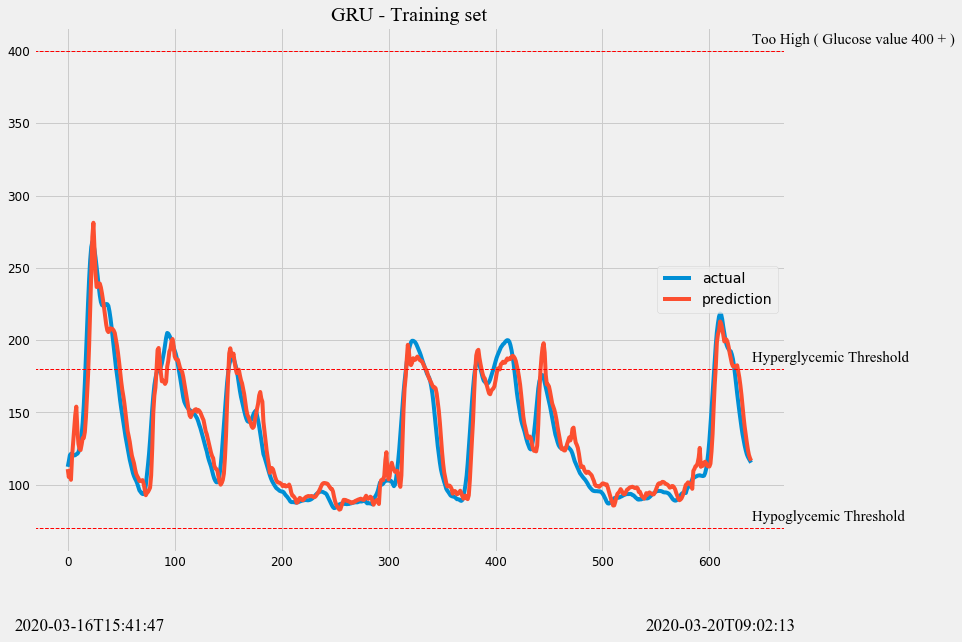

In [193]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

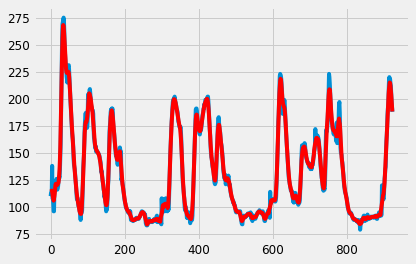

In [194]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [195]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [196]:
x_train_uni[0]

array([[114.28571429],
       [114.57142857],
       [114.85714286],
       [115.14285714],
       [114.14285714],
       [111.71428571]])

In [197]:
y_train_uni[0]

120.28571428571425

In [198]:
df['Glucose'].head(20)

0     110.00
1     113.00
2     114.50
3     115.25
4     138.00
5     108.00
6     108.00
7     103.00
8      96.00
9      96.00
10    112.00
11    118.00
12    121.00
13    122.00
14    122.00
15    122.00
16    126.00
17    119.00
18    116.00
19    118.00
Name: Glucose, dtype: float64

### RNN - 60분

In [199]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [200]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [201]:
K.clear_session()

In [202]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni,predict_result))
val_rnn_60 = RMSE(y_val_uni,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  24.604649361805293


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

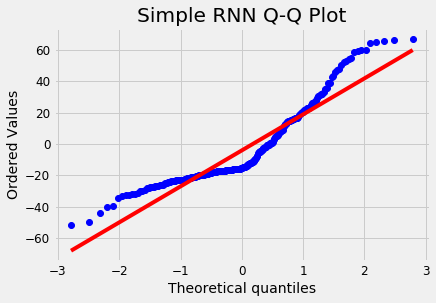

In [203]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

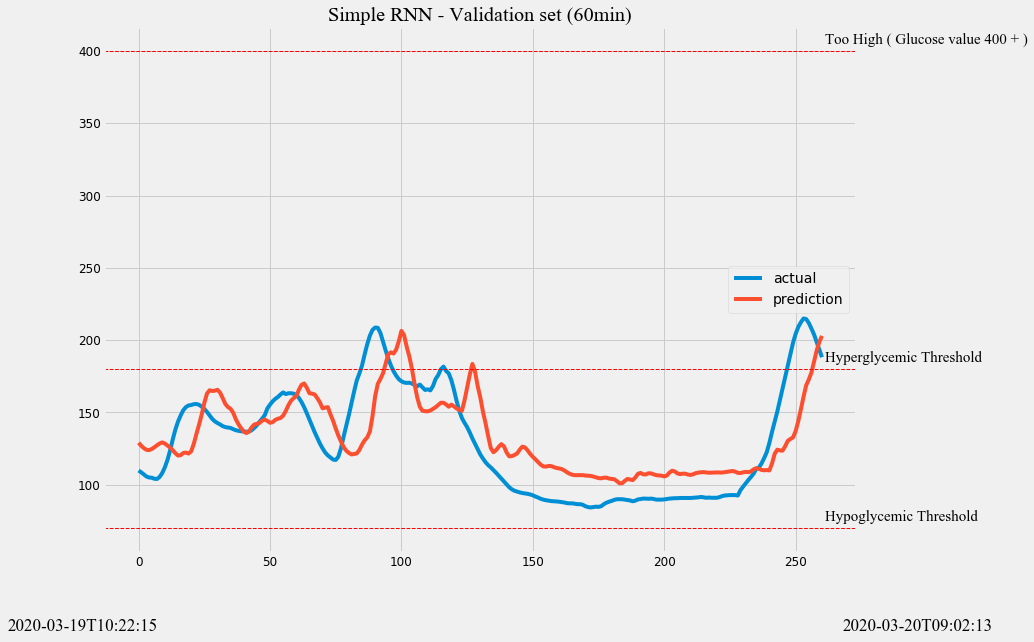

In [204]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

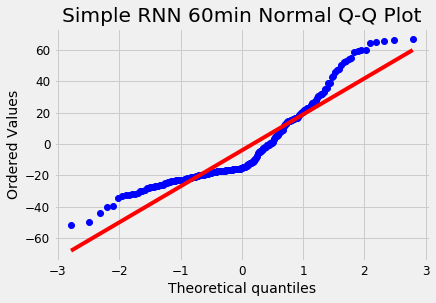

In [205]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [206]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni,predict_result))
train_rnn_60=RMSE(y_train_uni,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  29.602589076949528


#### Train

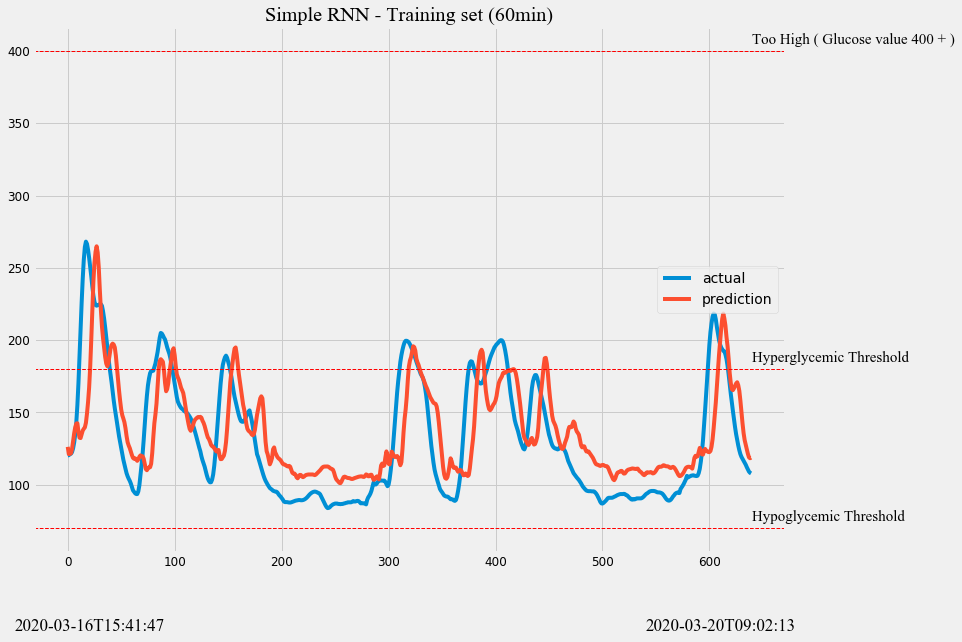

In [207]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [208]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [209]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [210]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni,predict_result))
val_lstm_60=RMSE(y_val_uni,predict_result)

 LSTM - RMSE (60min) :  22.87261892987909


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

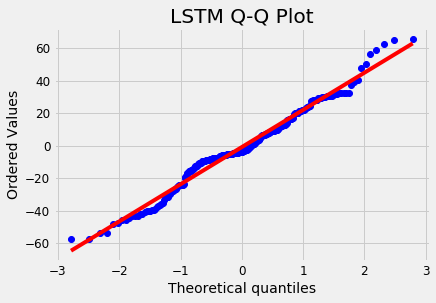

In [211]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

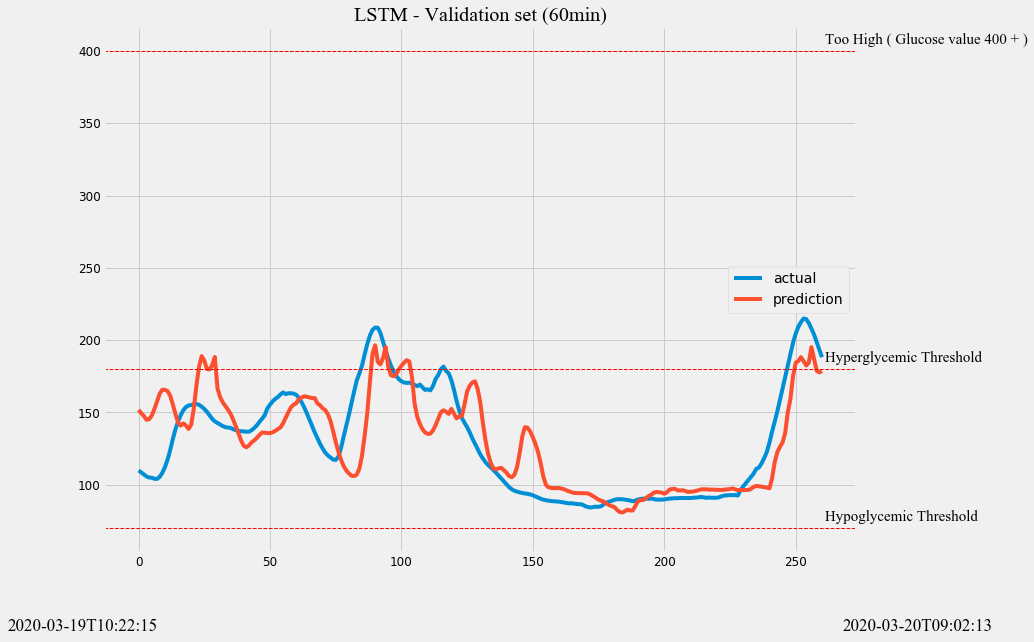

In [212]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [213]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))
train_lstm_60 =RMSE(y_train_uni,predict_result)

 LSTM - RMSE (60min) Training set :  25.61042824181483


#### Train

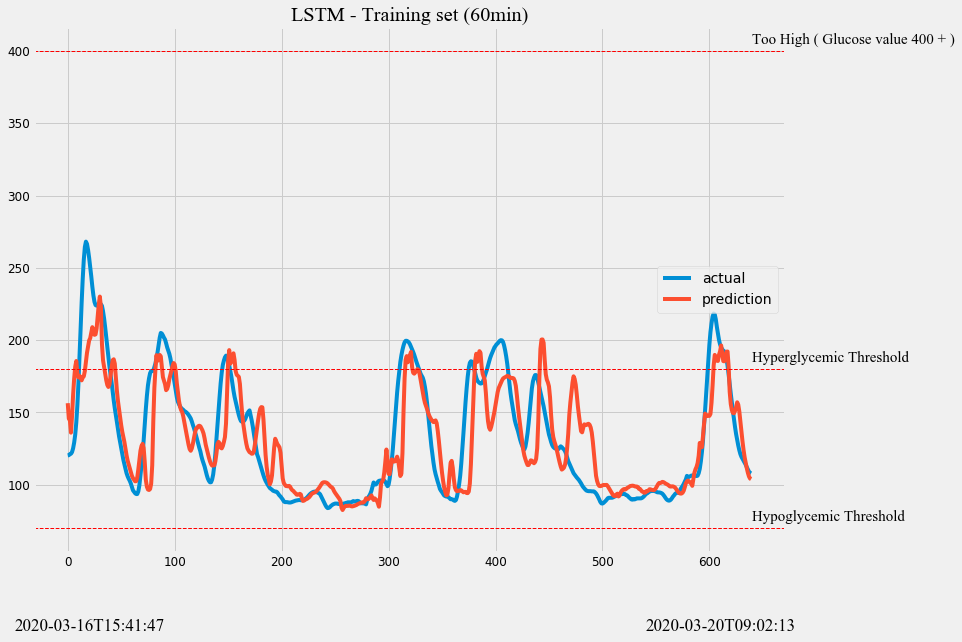

In [214]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [215]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [216]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [217]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [218]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni,predict_result))
val_stacklstm_60 =RMSE(y_val_uni,predict_result)

 Stacked LSTM - RMSE(15min) :  22.81007162286608


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

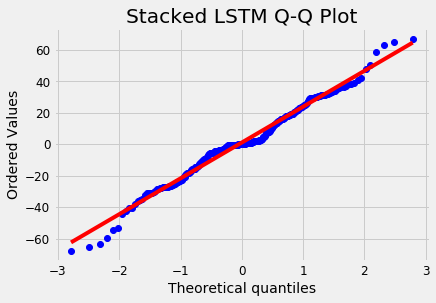

In [219]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

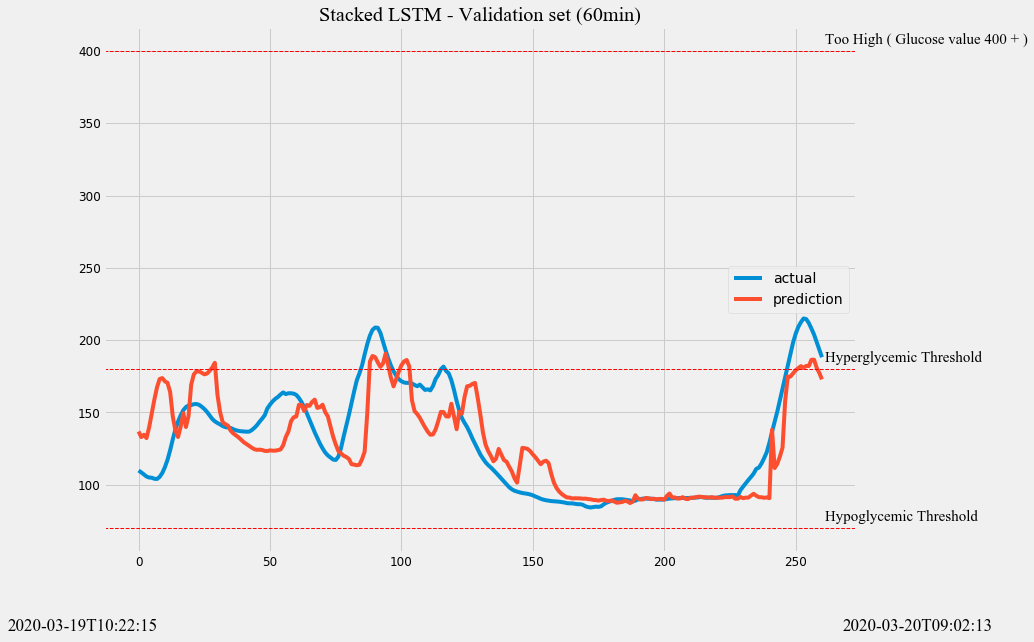

In [220]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [221]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))
train_stacklstm_60 = RMSE(y_train_uni,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  23.943628084926523


#### Train

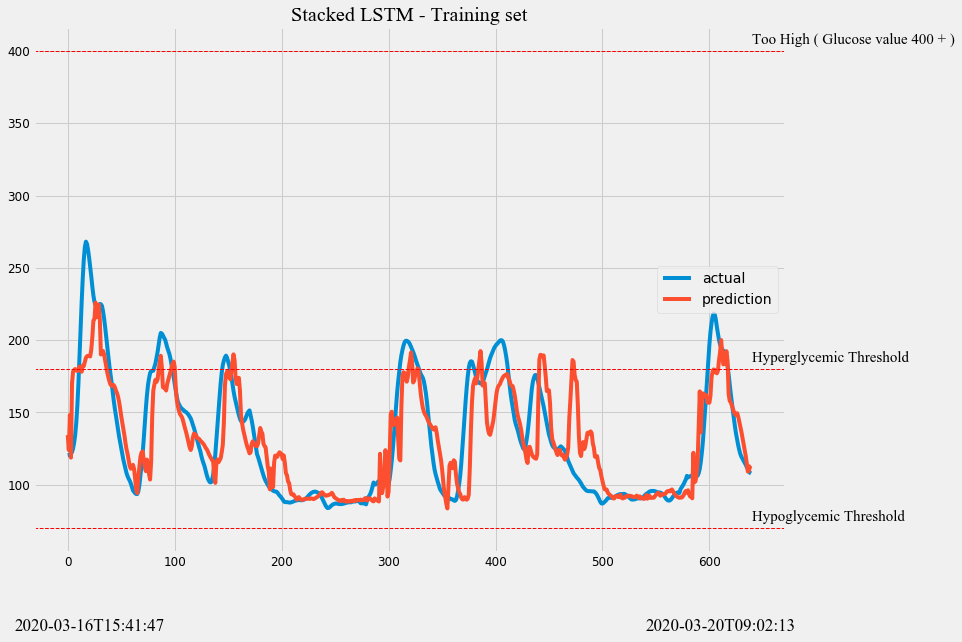

In [222]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [223]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [224]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [225]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [226]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni,predict_result))
val_bilstm_60 = RMSE(y_val_uni,predict_result)

Bidirectional LSTM - RMSE :  21.999747733299266


#### Validation

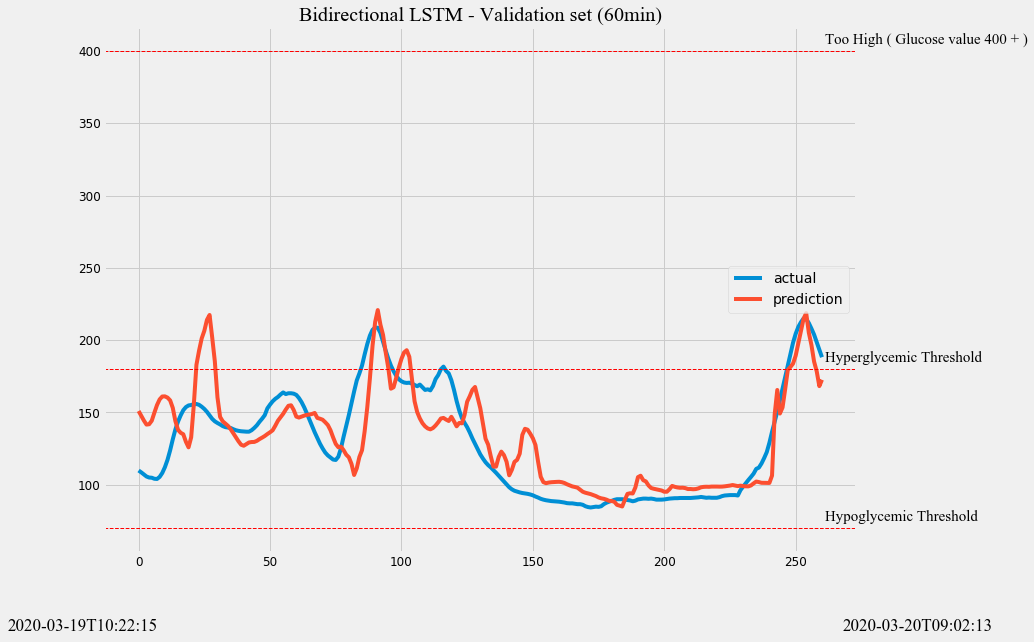

In [227]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

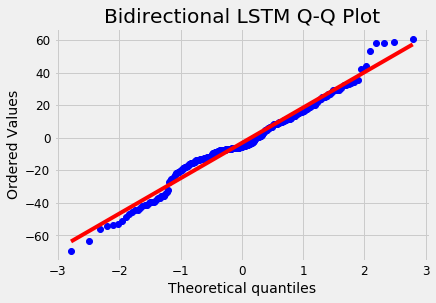

In [228]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [229]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))
train_bilstm_60 = RMSE(y_train_uni,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  25.97790170629843


#### Train

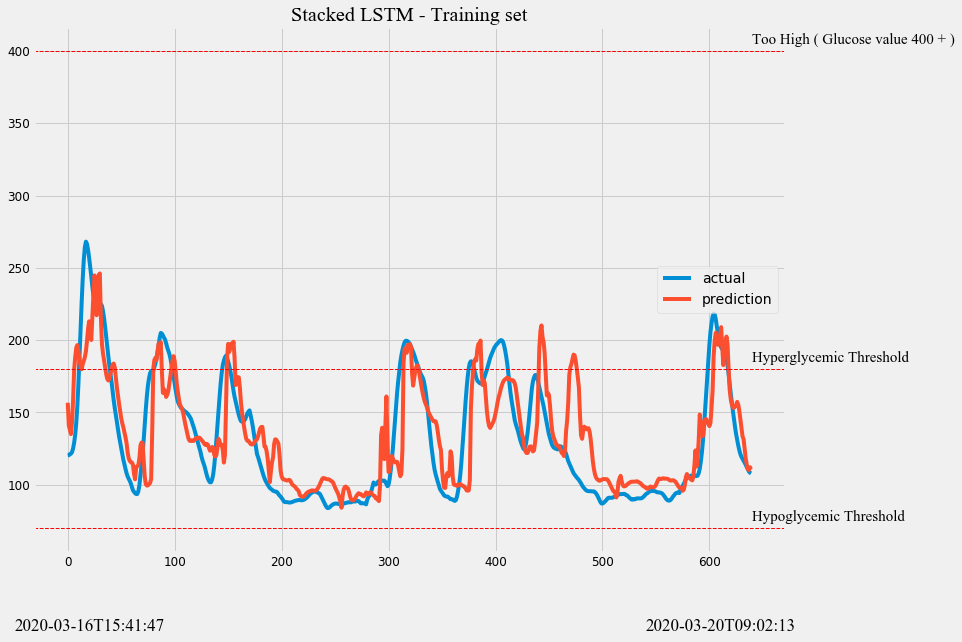

In [230]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [231]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [232]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [233]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [234]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_60 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  22.9414104210552


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

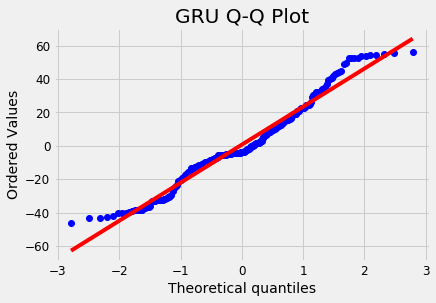

In [235]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

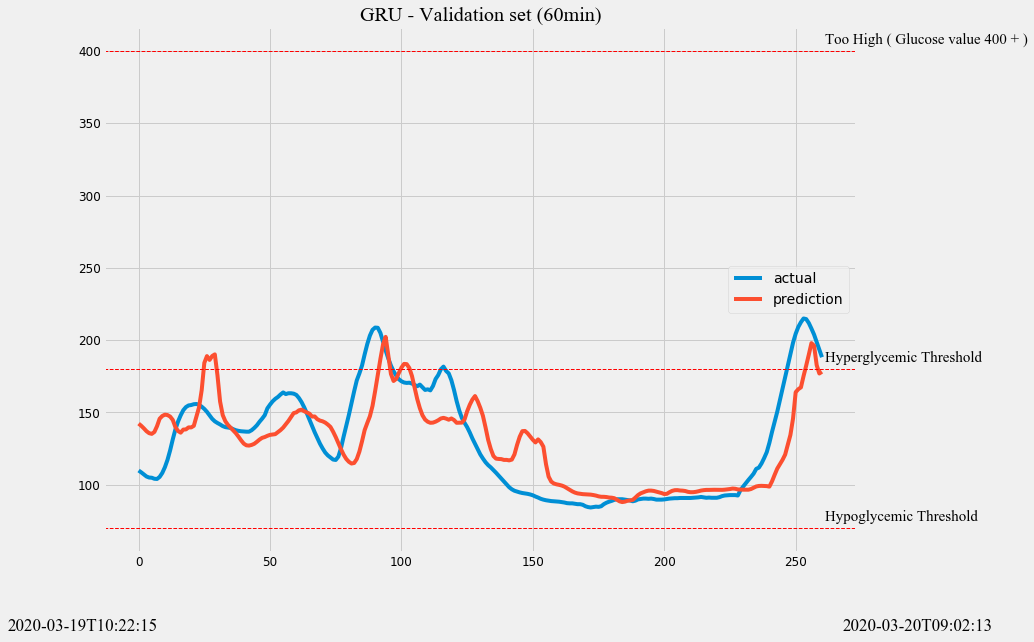

In [236]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [237]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))
train_gru_60 =RMSE(y_train_uni,predict_result)

 Training set / GRU - RMSE (60min) Training set :  27.76780286046742


#### Train

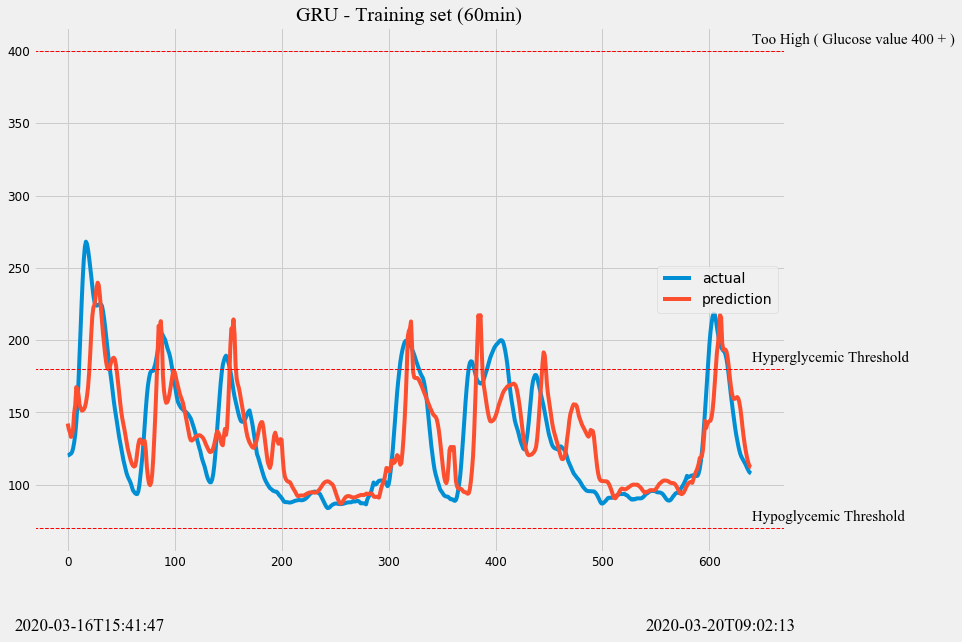

In [238]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [239]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [240]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [241]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [242]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [243]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [244]:
val_result_list

[[6.035478907646446, 11.624363717664115, 24.604649361805293],
 [8.637036871110967, 13.759030331521492, 22.87261892987909],
 [6.126397844003561, 10.726577274690678, 22.81007162286608],
 [5.480938046283358, 11.782337598429969, 21.999747733299266],
 [6.627783539971529, 9.753757596619186, 22.9414104210552]]

In [245]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

,15 MIN,30 MIN,60 MIN
RNN,6.035479,11.624364,24.604649
LSTM,8.637037,13.759030,22.872619
Stacked LSTM,6.126398,10.726577,22.810072
Bidirectional LSTM,5.480938,11.782338,21.999748
GRU,6.627784,9.753758,22.941410


In [246]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

,15 MIN,30 MIN,60 MIN
RNN,6.671243,13.738287,29.602589
LSTM,7.430845,14.634019,25.610428
Stacked LSTM,5.929586,13.210074,23.943628
Bidirectional LSTM,5.256477,12.026636,25.977902
GRU,6.454108,11.934726,27.767803


## CNN LSTM